<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
IN_COLAB = True

output_dir = 'results/'

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [1]:
!git clone https://github.com/evillag/uncertainty_gan.git
!mv uncertainty_gan/mcd .
!mv uncertainty_gan/feature_densities .
!mv uncertainty_gan/test_bench .
%rm -rf uncertainty_gan/

!git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
!mv lhcb-rich-gan-uncertainty/experiments .
!mv lhcb-rich-gan-uncertainty/src .
%rm -rf lhcb-rich-gan-uncertainty/
%rm -rf sample_data/
%pip install tensorflow-addons

Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 183 (delta 17), reused 4 (delta 3), pack-reused 147
Receiving objects: 100% (183/183), 21.42 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Cloning into 'lhcb-rich-gan-uncertainty'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (210/210), 2.94 MiB | 3.50 MiB/s, done.
Resolving deltas: 100% (94/94), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

In [5]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load results

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
results_dir = '/content/drive/MyDrive/cern/data/results/'

x_sample = np.load(results_dir + f'{PARTICLE}_x_real.npy')
y_sample = np.load(results_dir + f'{PARTICLE}_y_real.npy')
t_generated = np.load(results_dir + f'{PARTICLE}_t_generated.npy')

mcd_uncertainty = np.load(results_dir + f'{PARTICLE}_mcd_uncertainty.npy')
fd_uncertainty_normalized = np.load(results_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
fd_uncertainty_integration = np.load(results_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [32]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion_-_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion_-_up_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion2_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.8060131072998047
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(947963, 3)
targets_train shape	(947963, 5)
feats_val shape  	(525682, 3)
targets_val shape	(525682, 5)



In [33]:
# Draw a sample of the datasets
x_sample, y_sample = subsample_dataset(dataset['feats_val'], dataset['targets_val'], SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape

(TensorShape([100000, 3]), TensorShape([100000, 5]))

# Model creation

In [34]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [35]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 12s 3ms/step


(100000, 5)

In [37]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_sample.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_sample.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

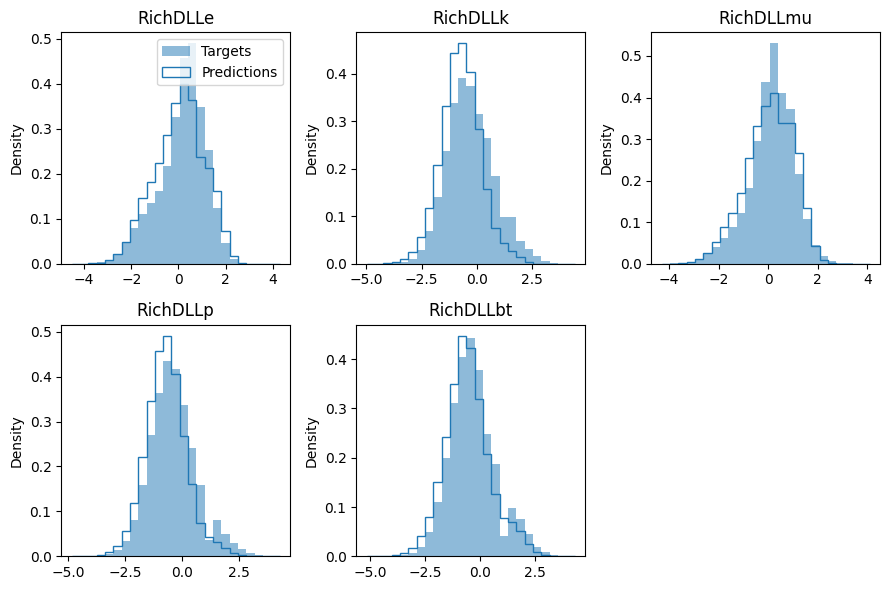

In [38]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [39]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None,
                                                 particle_index = 0, n_rows = 3, n_cols = 3, dll_columns=DLL_COLUMNS):
  n_rows, n_cols = 3, 3
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 2)

  js_distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

    js_dist = jensenshannon(predictions_hist, targets_hist)
    print('Jensen–Shannon distance:', js_dist)
    js_distances += [js_dist]

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  plt.show()

  return bin_edges, js_distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges[:-1], distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges[:-1], distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  for i in range(5):
    plt.plot(all_bin_ranges[i][:-1], all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(all_bin_ranges[i][:-1], all_distances[i])
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.legend()
  plt.show()

## Monte Carlo Dropout method

In [40]:
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model

mcd_uncertainty = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0]
mcd_uncertainty.shape

Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.17it/s]


TensorShape([100000, 5])

In [41]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_uncertainty)

### Plot MCD uncertainties

Jensen–Shannon distance: 0.20753269098038302
Jensen–Shannon distance: 0.2673834507878547
Jensen–Shannon distance: 0.19407420176642445
Jensen–Shannon distance: 0.1199888012692377
Jensen–Shannon distance: 0.10682773894503148
Jensen–Shannon distance: 0.11710220758212368
Jensen–Shannon distance: 0.1205898271640313
Jensen–Shannon distance: 0.1738889020833148
Jensen–Shannon distance: 0.2528195033658595


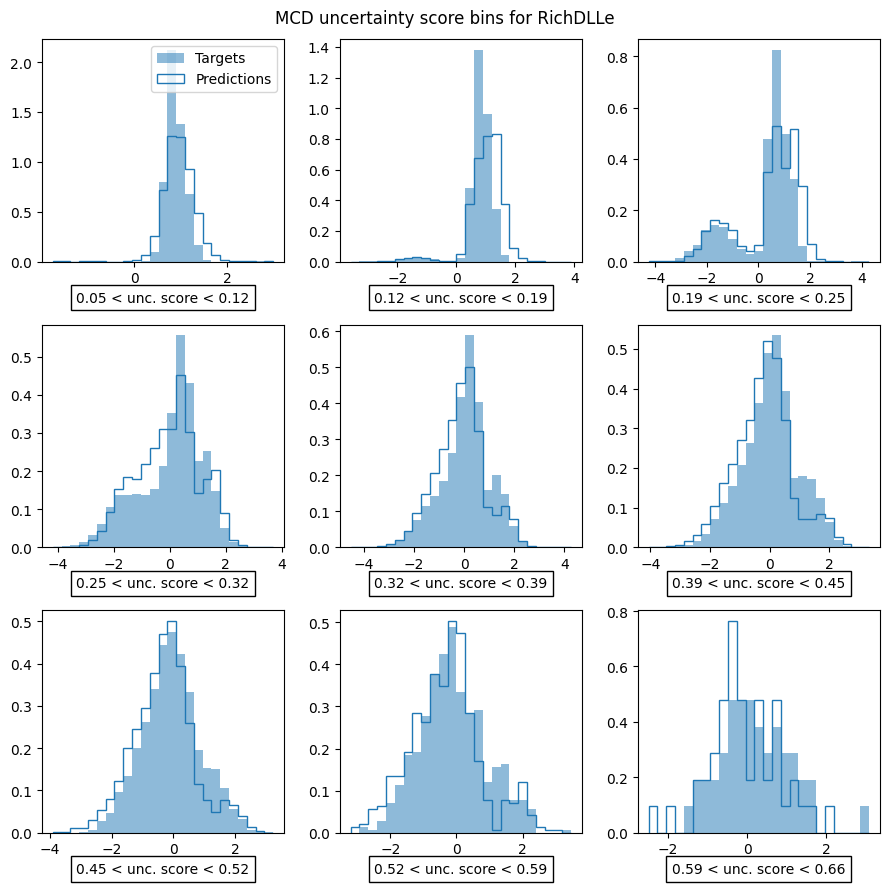

Jensen–Shannon distance: 0.46491528102997914
Jensen–Shannon distance: 0.367927614346297
Jensen–Shannon distance: 0.2558541977687339
Jensen–Shannon distance: 0.19384124337758601
Jensen–Shannon distance: 0.1463549051815529
Jensen–Shannon distance: 0.1179141171900168
Jensen–Shannon distance: 0.1117603020821358
Jensen–Shannon distance: 0.23413774842373228
Jensen–Shannon distance: 0.7036370562568


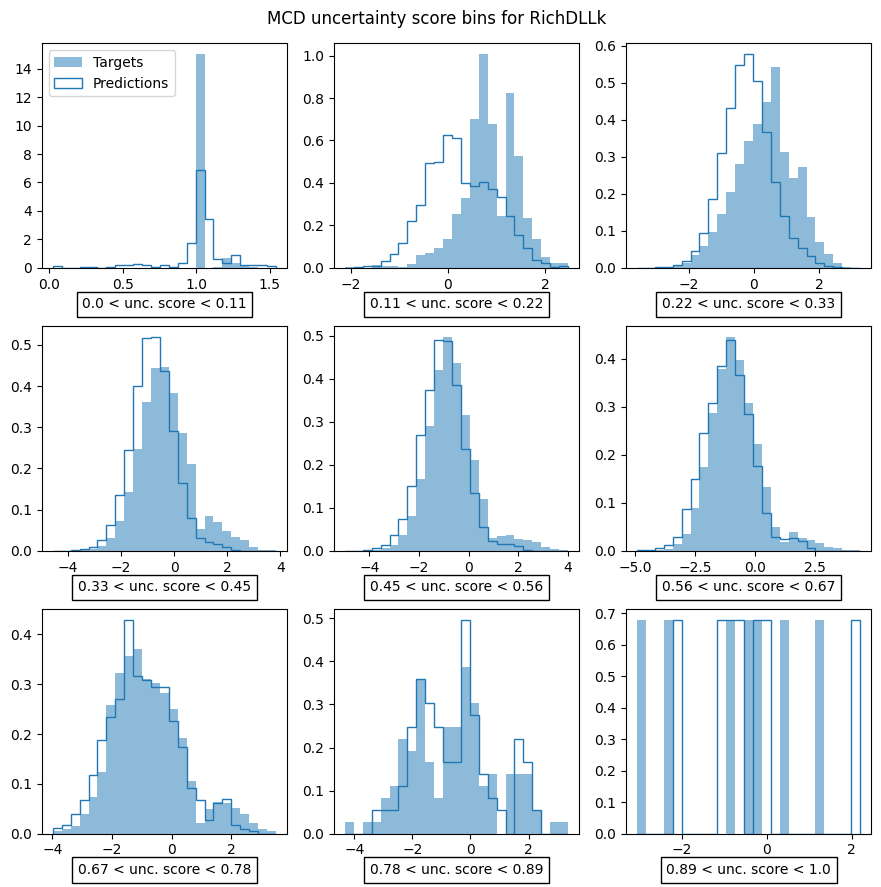

Jensen–Shannon distance: 0.2404116843701251
Jensen–Shannon distance: 0.17645053228938742
Jensen–Shannon distance: 0.12278478852110009
Jensen–Shannon distance: 0.08721300806958807
Jensen–Shannon distance: 0.12569650950421962
Jensen–Shannon distance: 0.11571195814433319
Jensen–Shannon distance: 0.09280746013277319
Jensen–Shannon distance: 0.12591764879872716
Jensen–Shannon distance: 0.3096720868923788


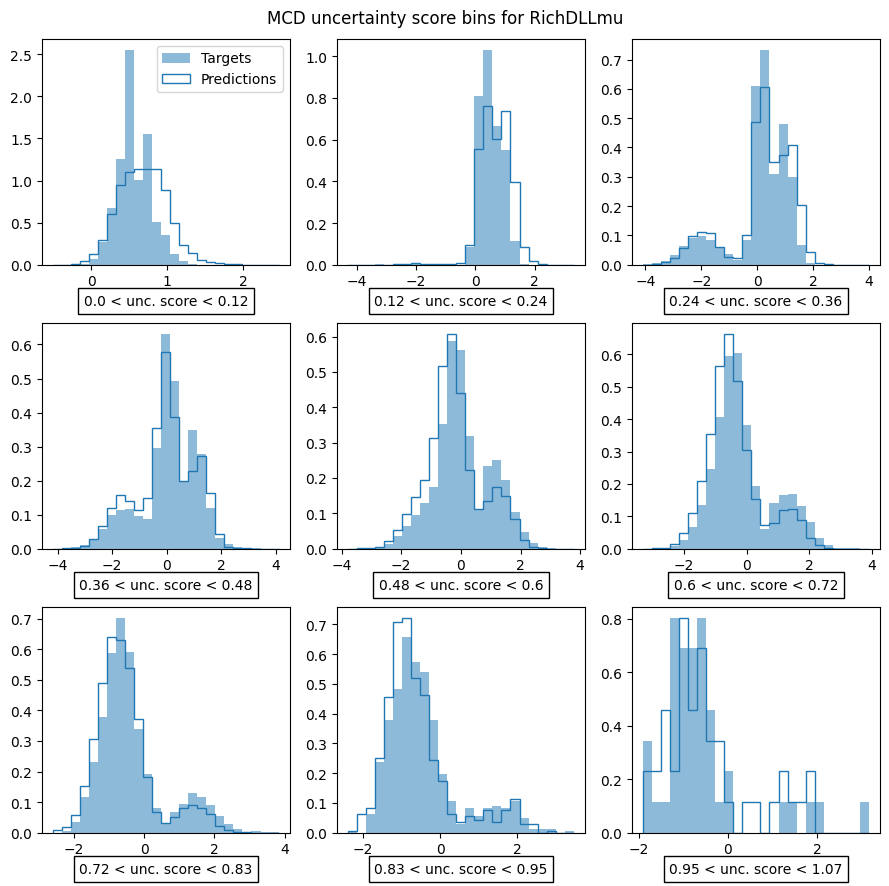

Jensen–Shannon distance: 0.4699849011396295
Jensen–Shannon distance: 0.2546888217619592
Jensen–Shannon distance: 0.15062581702687444
Jensen–Shannon distance: 0.17008869145450856
Jensen–Shannon distance: 0.11023144028943105
Jensen–Shannon distance: 0.07306681580624035
Jensen–Shannon distance: 0.09551931189485753
Jensen–Shannon distance: 0.19391158341738501
Jensen–Shannon distance: 0.47265507208741353


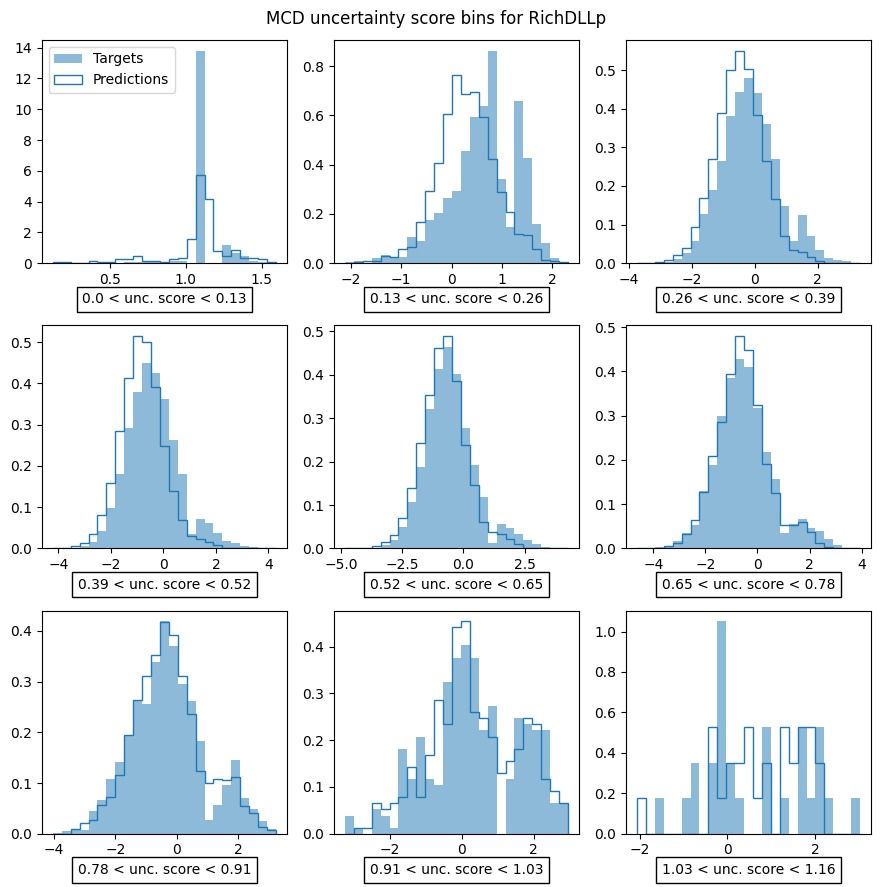

Jensen–Shannon distance: 0.22816148148370616
Jensen–Shannon distance: 0.07076411995600743
Jensen–Shannon distance: 0.12330424488840638
Jensen–Shannon distance: 0.11663689648970926
Jensen–Shannon distance: 0.08686762038749021
Jensen–Shannon distance: 0.08864391731462412
Jensen–Shannon distance: 0.13300006753016586
Jensen–Shannon distance: 0.3324177088243487
Jensen–Shannon distance: 0.8325546111576977


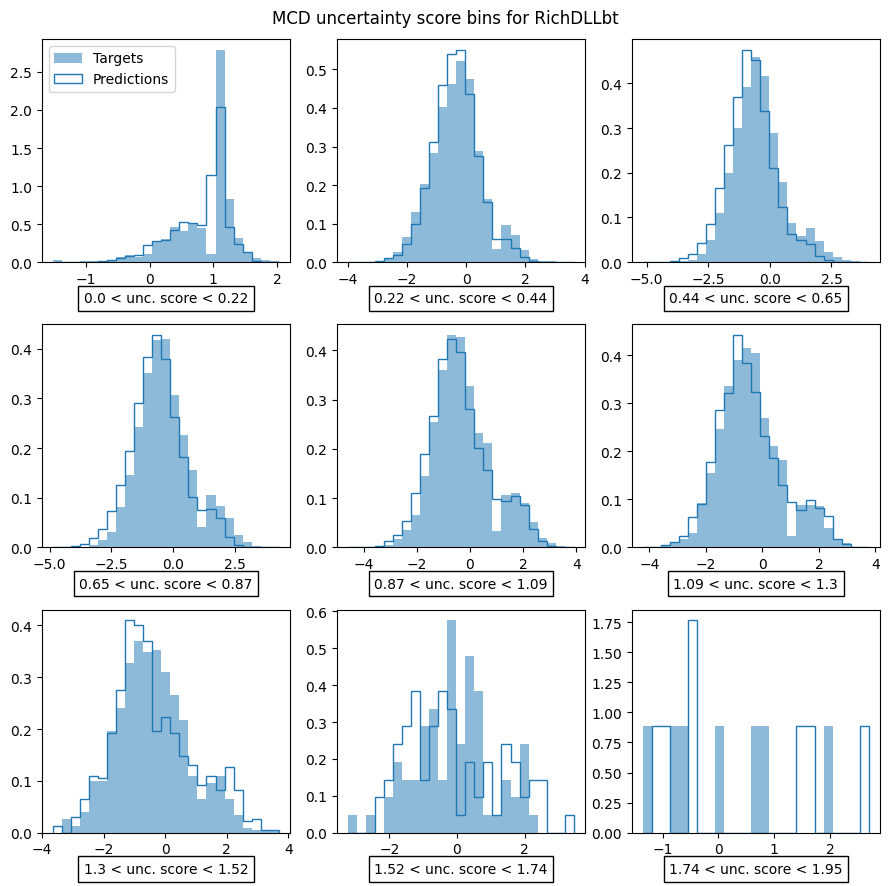

In [42]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)

  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: -0.18581086601548644
Correlation coefficient for RichDLLk: 0.04439961410641459
Correlation coefficient for RichDLLmu: 0.05756633085653761
Correlation coefficient for RichDLLp: -0.11383472011016568
Correlation coefficient for RichDLLbt: 0.5997547230266984


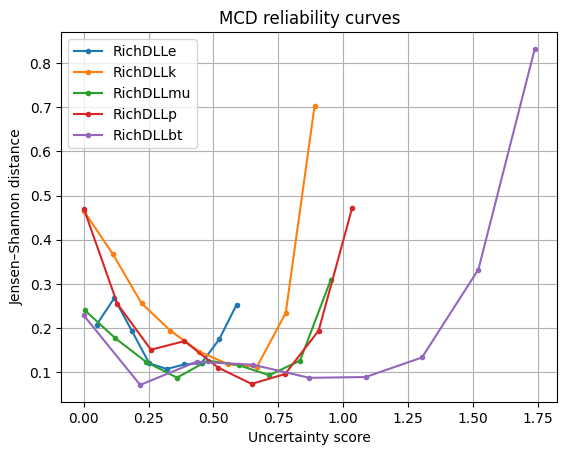

In [43]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

## Feature Densities method

### Uncertainty estimation

In [44]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model

train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)

In [45]:
fd_uncertainty_normalized = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=1000,
                                              likelihood_method='normalized')[0]

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized.shape

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 8s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [04:40<00:00,  2.19s/it]


Feature Densities using NORMALIZED uncertainty score for x_sample:


<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([0.44548442, 0.46448029, 0.3653381 , ..., 0.56015456, 0.76348514,
       0.71017395])>

In [46]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

Plot FD uncertainties

Jensen–Shannon distance: 0.07931987860621587
Jensen–Shannon distance: 0.06562594251778436
Jensen–Shannon distance: 0.07781218805023152
Jensen–Shannon distance: 0.09058201346468644
Jensen–Shannon distance: 0.10449369005528984
Jensen–Shannon distance: 0.12598241179754613
Jensen–Shannon distance: 0.16159276899802205
Jensen–Shannon distance: 0.2260588728139113
Jensen–Shannon distance: 0.336180211877575


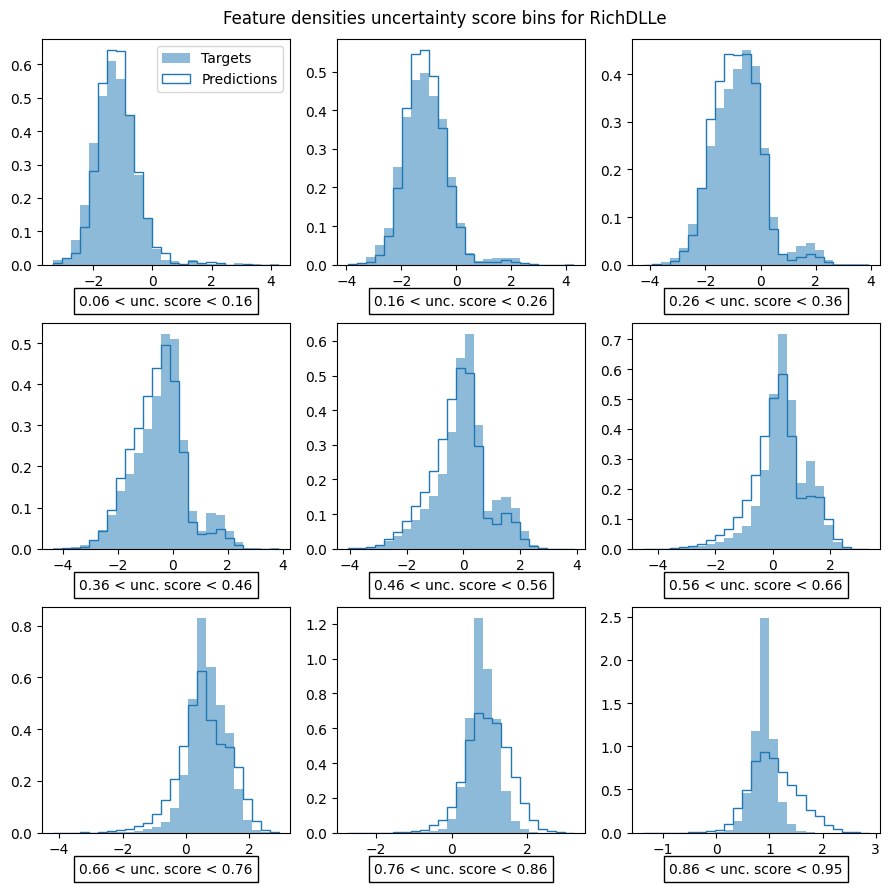

Jensen–Shannon distance: 0.0755112354218557
Jensen–Shannon distance: 0.0689842105630312
Jensen–Shannon distance: 0.06919156201945853
Jensen–Shannon distance: 0.08109426663652954
Jensen–Shannon distance: 0.1168122407265892
Jensen–Shannon distance: 0.18574814245347968
Jensen–Shannon distance: 0.2724878212053531
Jensen–Shannon distance: 0.3509054332407264
Jensen–Shannon distance: 0.435481079112982


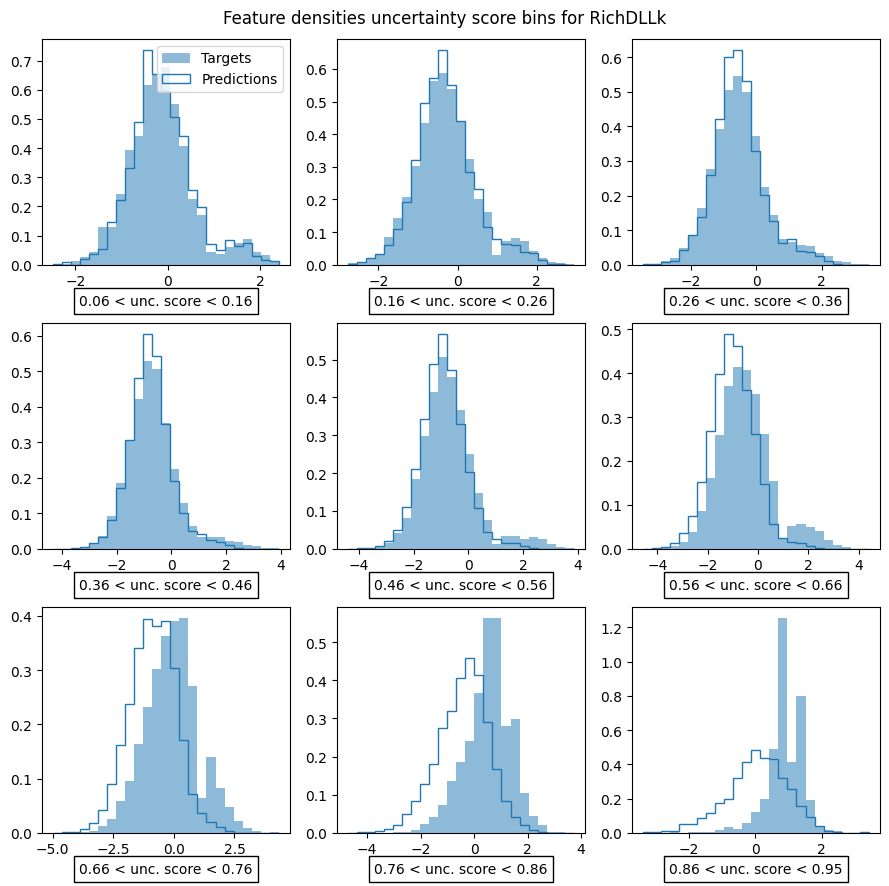

Jensen–Shannon distance: 0.08737993387340916
Jensen–Shannon distance: 0.07381213315357475
Jensen–Shannon distance: 0.08616899356319574
Jensen–Shannon distance: 0.09682957580996675
Jensen–Shannon distance: 0.10451289646765352
Jensen–Shannon distance: 0.11825347048270524
Jensen–Shannon distance: 0.13854078989471147
Jensen–Shannon distance: 0.1868830548512201
Jensen–Shannon distance: 0.29787751016794506


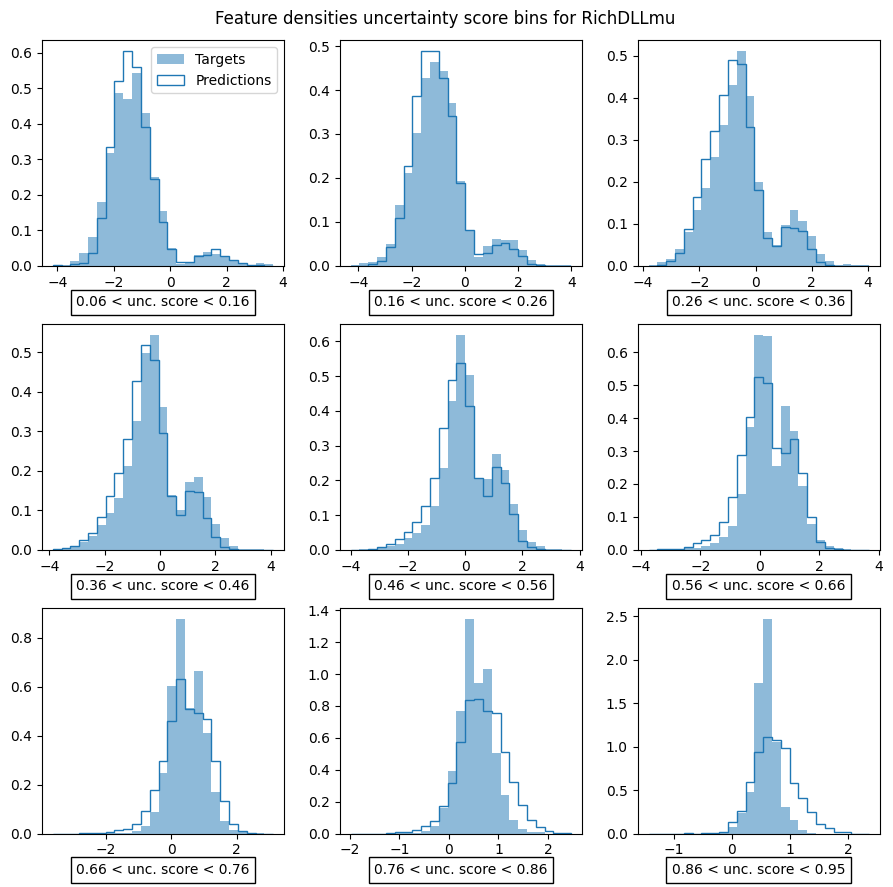

Jensen–Shannon distance: 0.0773398373049333
Jensen–Shannon distance: 0.05972618601719496
Jensen–Shannon distance: 0.07822548462922553
Jensen–Shannon distance: 0.08757666789298604
Jensen–Shannon distance: 0.10504605523725435
Jensen–Shannon distance: 0.10918699879538797
Jensen–Shannon distance: 0.1540780186882924
Jensen–Shannon distance: 0.2636621631206881
Jensen–Shannon distance: 0.447944256230226


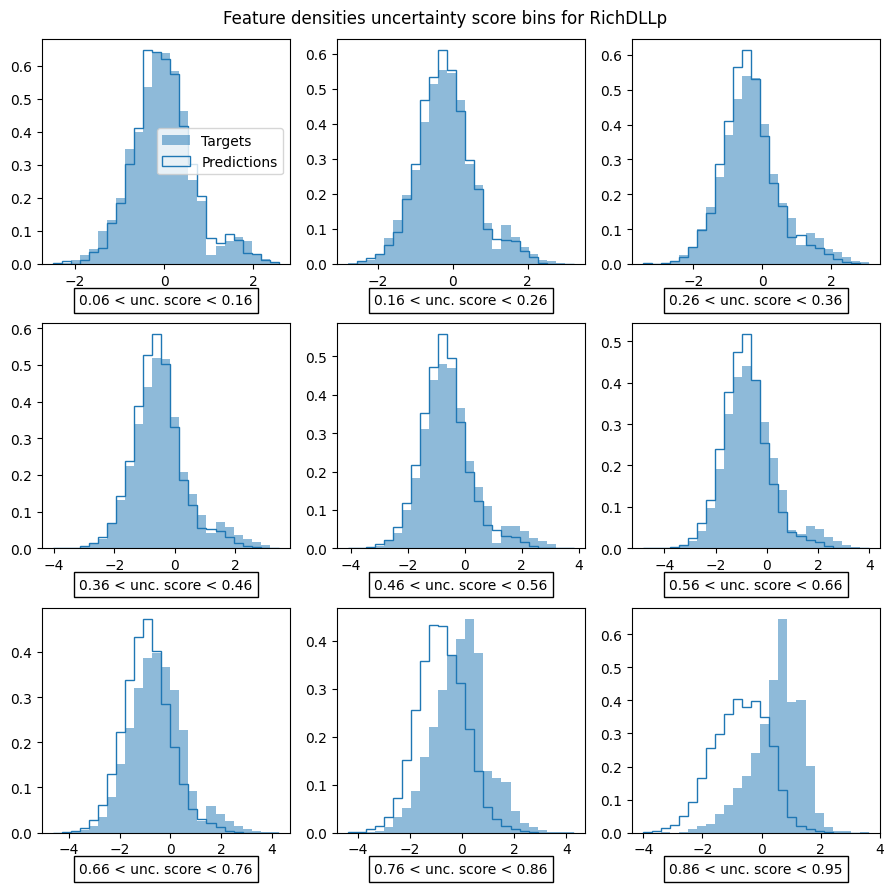

Jensen–Shannon distance: 0.07502329556402058
Jensen–Shannon distance: 0.05833423724132553
Jensen–Shannon distance: 0.07245909045776851
Jensen–Shannon distance: 0.0922216672630581
Jensen–Shannon distance: 0.10548761338149003
Jensen–Shannon distance: 0.11994707802227907
Jensen–Shannon distance: 0.12010320969340914
Jensen–Shannon distance: 0.11479172216441023
Jensen–Shannon distance: 0.13435707317824602


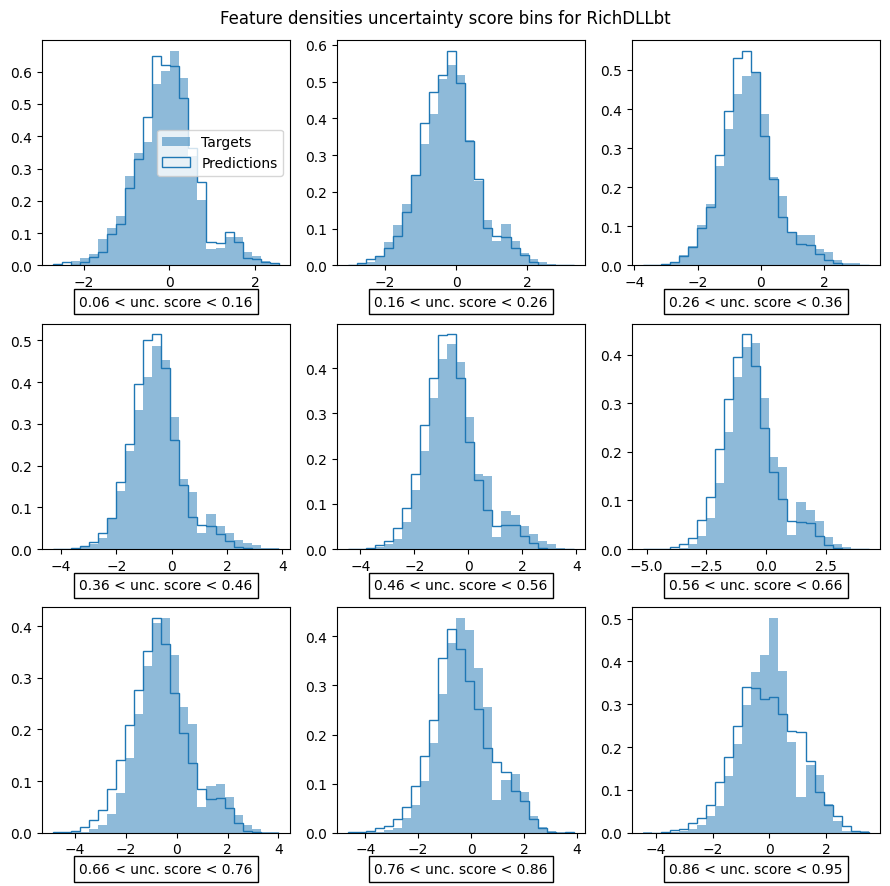

In [47]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.8780882484642886
Correlation coefficient for RichDLLk: 0.9254837459584626
Correlation coefficient for RichDLLmu: 0.8415045781011778
Correlation coefficient for RichDLLp: 0.8190262442080578
Correlation coefficient for RichDLLbt: 0.9302517840050271


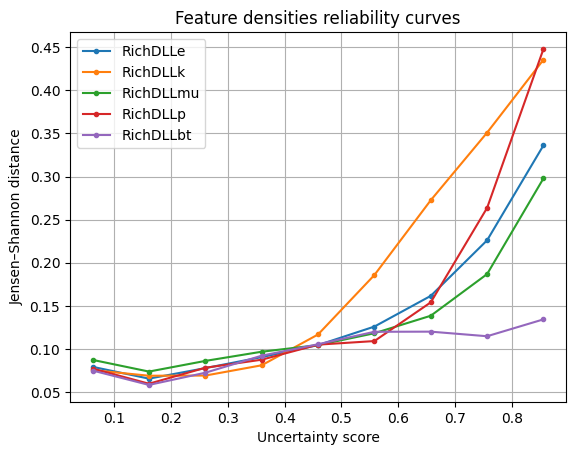

In [48]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

## Uncertainty heatmaps

In [17]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

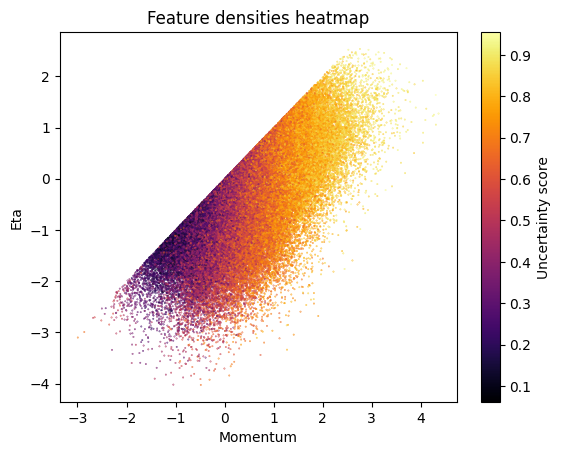

In [49]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [23]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

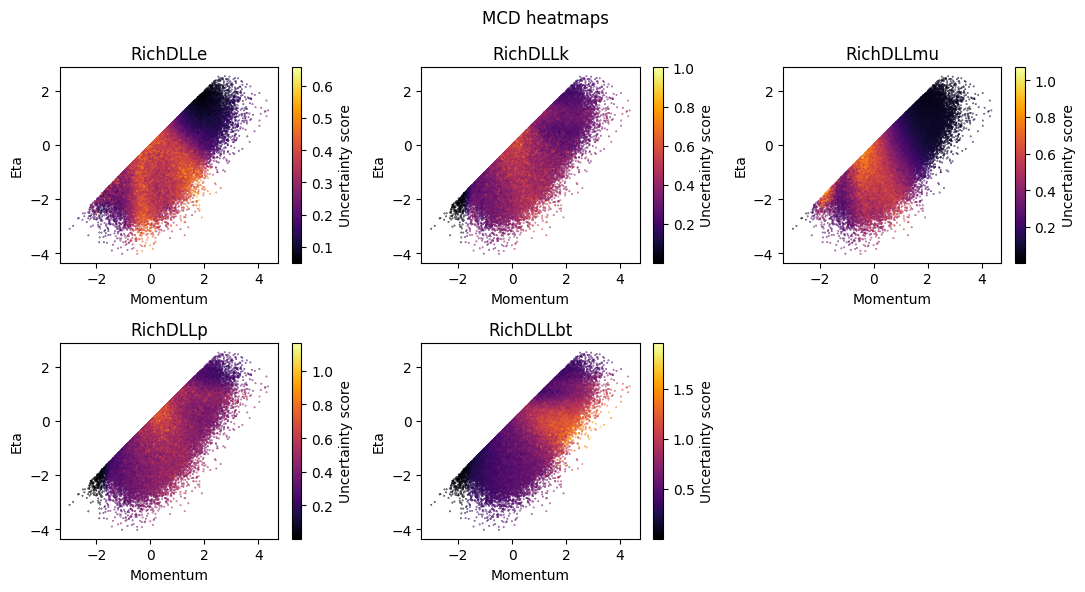

In [50]:
uncertainty_scatter_plot_mcd(x_sample, mcd_uncertainty)

# Efficiency plots

In [64]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

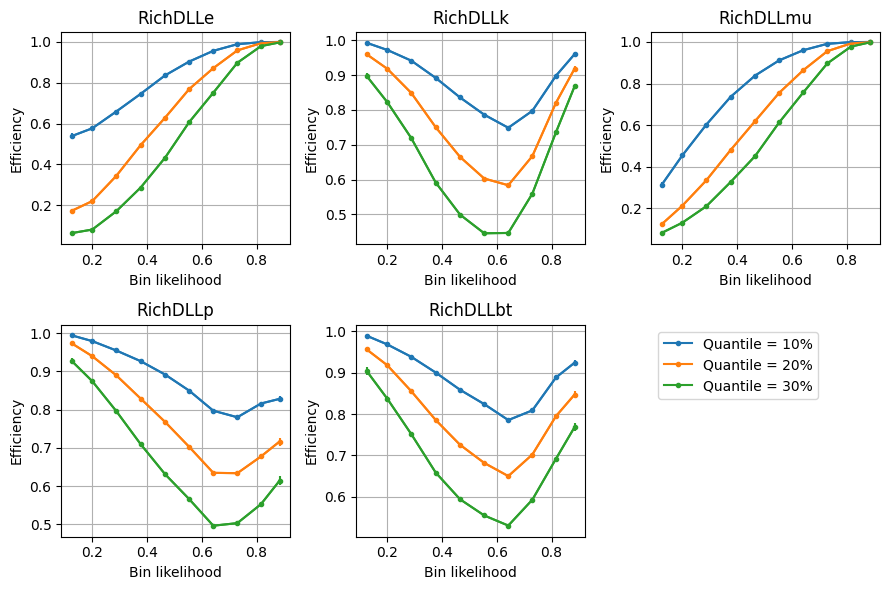

In [65]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

# Archived

#### FD with integration method


In [ ]:
# fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, likelihood_method='integration')

# print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
# fd_uncertainty_integration

(948325, 128)
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample´s embeddings
2/2 [==============================] - 0s 6ms/step
Estimating sample´s feature densities


100%|██████████| 52/52 [10:21<00:00, 11.95s/it]

Feature Densities using INTEGRATION uncertainty score for x_sample:


<tf.Tensor: shape=(52,), dtype=float64, numpy=
array([0.99696795, 0.98386122, 0.9930798 , 0.99029255, 0.99388116,
       0.99106039, 0.98962542, 0.99185572, 0.98346811, 0.99297008,
       0.99250436, 0.99122989, 0.99037003, 0.97890695, 0.99057272,
       0.99336079, 0.98162482, 0.9881128 , 0.98746889, 0.99346868,
       0.99161914, 0.98390812, 0.98245716, 0.98058026, 0.97937096,
       0.99569436, 0.98796848, 0.9909012 , 0.98491409, 0.99193857,
       0.98075132, 0.99061284, 0.99276764, 0.98459823, 0.98762967,
       0.9787404 , 0.98669493, 0.98364207, 0.98975249, 0.98866702,
       0.99224149, 0.9924707 , 0.99271423, 0.99475767, 0.99674197,
       0.99607984, 0.99230945, 0.98954991, 0.99243532, 0.99160392,
       0.98236469, 0.98252359])>

In [ ]:
# Save FD uncertainties with integration
# np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)

In [ ]:
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])

In [ ]:
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

In [ ]:
# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)